# Setup

## Imports

In [31]:
import time
from timeit import default_timer as timer
import numpy as np
from functools import wraps
import cProfile
import subprocess
import matplotlib.pyplot as plt
from scipy.special import gamma
# from sph_profile import main as sph_run
NAME = ""

## Functions from sph

In [24]:
def W( x, y, z, h ):
	"""
    Gausssian Smoothing kernel (3D)
	x     is a vector/matrix of x positions
	y     is a vector/matrix of y positions
	z     is a vector/matrix of z positions
	h     is the smoothing length
	w     is the evaluated smoothing function
	"""
	
	r = np.sqrt(x**2 + y**2 + z**2)
	
	w = (1.0 / (h*np.sqrt(np.pi)))**3 * np.exp( -r**2 / h**2)
	
	return w
	
	
def gradW( x, y, z, h ):
	"""
	Gradient of the Gausssian Smoothing kernel (3D)
	x     is a vector/matrix of x positions
	y     is a vector/matrix of y positions
	z     is a vector/matrix of z positions
	h     is the smoothing length
	wx, wy, wz     is the evaluated gradient
	"""
	
	r = np.sqrt(x**2 + y**2 + z**2)
	
	n = -2 * np.exp( -r**2 / h**2) / h**5 / (np.pi)**(3/2)
	wx = n * x
	wy = n * y
	wz = n * z
	
	return wx, wy, wz
	
	
def getPairwiseSeparations( ri, rj ):
	"""
	Get pairwise desprations between 2 sets of coordinates
	ri    is an M x 3 matrix of positions
	rj    is an N x 3 matrix of positions
	dx, dy, dz   are M x N matrices of separations
	"""
	
	M = ri.shape[0]
	N = rj.shape[0]
	
	# positions ri = (x,y,z)
	rix = ri[:,0].reshape((M,1))
	riy = ri[:,1].reshape((M,1))
	riz = ri[:,2].reshape((M,1))
	
	# other set of points positions rj = (x,y,z)
	rjx = rj[:,0].reshape((N,1))
	rjy = rj[:,1].reshape((N,1))
	rjz = rj[:,2].reshape((N,1))
	
	# matrices that store all pairwise particle separations: r_i - r_j
	dx = rix - rjx.T
	dy = riy - rjy.T
	dz = riz - rjz.T
	
	return dx, dy, dz
	

def getDensity( r, pos, m, h ):
	"""
	Get Density at sampling loctions from SPH particle distribution
	r     is an M x 3 matrix of sampling locations
	pos   is an N x 3 matrix of SPH particle positions
	m     is the particle mass
	h     is the smoothing length
	rho   is M x 1 vector of densities
	"""
	
	M = r.shape[0]
	
	dx, dy, dz = getPairwiseSeparations( r, pos );
	
	rho = np.sum( m * W(dx, dy, dz, h), 1 ).reshape((M,1))
	
	return rho
	
	
def getPressure(rho, k, n):
	"""
	Equation of State
	rho   vector of densities
	k     equation of state constant
	n     polytropic index
	P     pressure
	"""
	
	P = k * rho**(1+1/n)
	
	return P
	

def getAcc( pos, vel, m, h, k, n, lmbda, nu ):
	"""
	Calculate the acceleration on each SPH particle
	pos   is an N x 3 matrix of positions
	vel   is an N x 3 matrix of velocities
	m     is the particle mass
	h     is the smoothing length
	k     equation of state constant
	n     polytropic index
	lmbda external force constant
	nu    viscosity
	a     is N x 3 matrix of accelerations
	"""
	
	N = pos.shape[0]
	
	# Calculate densities at the position of the particles
	rho = getDensity( pos, pos, m, h )
	
	# Get the pressures
	P = getPressure(rho, k, n)
	
	# Get pairwise distances and gradients
	dx, dy, dz = getPairwiseSeparations( pos, pos )
	dWx, dWy, dWz = gradW( dx, dy, dz, h )
	
	# Add Pressure contribution to accelerations
	ax = - np.sum( m * ( P/rho**2 + P.T/rho.T**2  ) * dWx, 1).reshape((N,1))
	ay = - np.sum( m * ( P/rho**2 + P.T/rho.T**2  ) * dWy, 1).reshape((N,1))
	az = - np.sum( m * ( P/rho**2 + P.T/rho.T**2  ) * dWz, 1).reshape((N,1))
	
	# pack together the acceleration components
	a = np.hstack((ax,ay,az))
	
	# Add external potential force
	a -= lmbda * pos
	
	# Add viscosity
	a -= nu * vel
	
	return a

def main():
	""" SPH simulation """
	
	# Simulation parameters
	N         = 400    # Number of particles
	t         = 0      # current time of the simulation
	tEnd      = 12     # time at which simulation ends
	dt        = 0.04   # timestep
	M         = 2      # star mass
	R         = 0.75   # star radius
	h         = 0.1    # smoothing length
	k         = 0.1    # equation of state constant
	n         = 1      # polytropic index
	nu        = 1      # damping
	plotRealTime = False # switch on for plotting as the simulation goes along
	
	# Generate Initial Conditions
	np.random.seed(42)            # set the random number generator seed
	
	lmbda = 2*k*(1+n)*np.pi**(-3/(2*n)) * (M*gamma(5/2+n)/R**3/gamma(1+n))**(1/n) / R**2  # ~ 2.01
	m     = M/N                    # single particle mass
	pos   = np.random.randn(N,3)   # randomly selected positions and velocities
	vel   = np.zeros(pos.shape)
	
	# calculate initial gravitational accelerations
	acc = getAcc( pos, vel, m, h, k, n, lmbda, nu )
	
	# number of timesteps
	Nt = int(np.ceil(tEnd/dt))
	
	# prep figure
	fig = plt.figure(figsize=(4,5), dpi=80)
	grid = plt.GridSpec(3, 1, wspace=0.0, hspace=0.3)
	ax1 = plt.subplot(grid[0:2,0])
	ax2 = plt.subplot(grid[2,0])
	rr = np.zeros((100,3))
	rlin = np.linspace(0,1,100)
	rr[:,0] =rlin
	rho_analytic = lmbda/(4*k) * (R**2 - rlin**2)
	
	# Simulation Main Loop
	for i in range(Nt):
		# (1/2) kick
		vel += acc * dt/2
		
		# drift
		pos += vel * dt
		
		# update accelerations
		acc = getAcc( pos, vel, m, h, k, n, lmbda, nu )
		
		# (1/2) kick
		vel += acc * dt/2
		
		# update time
		t += dt
		
		# get density for plotting
		rho = getDensity( pos, pos, m, h )
		
		# plot in real time
		if plotRealTime or (i == Nt-1):
			plt.sca(ax1)
			plt.cla()
			cval = np.minimum((rho-3)/3,1).flatten()
			plt.scatter(pos[:,0],pos[:,1], c=cval, cmap=plt.cm.autumn, s=10, alpha=0.5)
			ax1.set(xlim=(-1.4, 1.4), ylim=(-1.2, 1.2))
			ax1.set_aspect('equal', 'box')
			ax1.set_xticks([-1,0,1])
			ax1.set_yticks([-1,0,1])
			ax1.set_facecolor('black')
			ax1.set_facecolor((.1,.1,.1))
			
			plt.sca(ax2)
			plt.cla()
			ax2.set(xlim=(0, 1), ylim=(0, 3))
			ax2.set_aspect(0.1)
			plt.plot(rlin, rho_analytic, color='gray', linewidth=2)
			rho_radial = getDensity( rr, pos, m, h )
			plt.plot(rlin, rho_radial, color='blue')
			plt.pause(0.001)
	    
	# add labels/legend
	plt.sca(ax2)
	plt.xlabel('radius')
	plt.ylabel('density')
	
	# Save figure
	# plt.savefig('sph.png',dpi=240)
	# plt.show()
	    
	return 0
	
	def sph():
		main()

## CPU Profiler

In [17]:
import psutil
import time
import matplotlib.pyplot as plt
import pandas as pd
from functools import wraps

# Tool for recording CPU usage
class CPUProfiler:
    def __init__(self):
        self.data = []
        self.start_time = None

    def start(self):
        self.start_time = time.time()

    def record(self):
        if self.start_time is None:
            raise RuntimeError("Profiler has not been started.")
        elapsed_time = time.time() - self.start_time
        cpu_usage = psutil.cpu_percent(interval=1, percpu=True)
        self.data.append((elapsed_time, cpu_usage))

    def save_data(self, filename="cpu_usage.csv"):
        df = pd.DataFrame(self.data, columns=["Time (s)", "CPU Usage"])
        df.to_csv(filename, index=False)

    def plot(self):
        # Create a DataFrame for visualization
        times = [entry[0] for entry in self.data]
        usage = [entry[1] for entry in self.data]

        usage_transposed = list(zip(*usage))
        for core_idx, core_usage in enumerate(usage_transposed):
            plt.plot(times, core_usage, label=f"Core {core_idx}")
        
        plt.xlabel("Time (s)")
        plt.ylabel("CPU Usage (%)")
        plt.title("CPU Usage Per Core")
        plt.legend()
        plt.grid(True)
        plt.show()

    def summary_table(self):
        usage = [entry[1] for entry in self.data]
        avg_usage = [sum(core) / len(usage) for core in zip(*usage)]
        summary = pd.DataFrame({
            "Core": [f"Core {i}" for i in range(len(avg_usage))],
            "Average CPU Usage (%)": avg_usage
        })
        return summary

# Decorator to profile a function
def profile(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        profiler.record()  # Record before function call
        result = func(*args, **kwargs)
        profiler.record()  # Record after function call
        return result
    return wrapper

# Initialize profiler
profiler = CPUProfiler()

# Function implementations
grid_shape = (320, 320)

@profile
def evolve(grid, dt, D=1.0):
    xmax, ymax = grid_shape
    new_grid = [[0.0] * ymax for x in range(xmax)]
    for i in range(xmax):
        for j in range(ymax):
            grid_xx = (
                grid[(i + 1) % xmax][j] + grid[(i - 1) % xmax][j] - 2.0 * grid[i][j]
            )
            grid_yy = (
                grid[i][(j + 1) % ymax] + grid[i][(j - 1) % ymax] - 2.0 * grid[i][j]
            )
            new_grid[i][j] = grid[i][j] + D * (grid_xx + grid_yy) * dt
    return new_grid

def run_experiment(num_iterations):
    # Setting up initial conditions 
    xmax, ymax = grid_shape
    grid = [[0.0] * ymax for x in range(xmax)]

    # Simulating a drop of dye in the middle of our simulated region
    block_low = int(grid_shape[0] * 0.4)
    block_high = int(grid_shape[0] * 0.5)
    for i in range(block_low, block_high):
        for j in range(block_low, block_high):
            grid[i][j] = 0.005

    # Evolve the initial conditions
    for i in range(num_iterations):
        grid = evolve(grid, 0.1)

# Profiling

## Profiling with cProfile

### cProfile

In [3]:
! python -m cProfile -s cumulative sph.py

Figure(320x400)
         1888531 function calls (1851619 primitive calls) in 12.859 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   1030/1    0.016    0.000   12.861   12.861 {built-in method builtins.exec}
        1    0.000    0.000   12.861   12.861 sph.py:1(<module>)
        1    0.265    0.265   11.127   11.127 sph.py:155(main)
      301    1.602    0.005    7.287    0.024 sph.py:111(getAcc)
      127    0.006    0.000    6.118    0.048 __init__.py:1(<module>)
      602    0.407    0.001    5.040    0.008 sph.py:78(getDensity)
      602    3.626    0.006    3.626    0.006 sph.py:12(W)
   1128/4    0.012    0.000    2.588    0.647 <frozen importlib._bootstrap>:1165(_find_and_load)
   1122/4    0.008    0.000    2.588    0.647 <frozen importlib._bootstrap>:1120(_find_and_load_unlocked)
   2559/9    0.003    0.000    2.583    0.287 <frozen importlib._bootstrap>:233(_call_with_frames_removed)
   1087/6    0.006    0.0

In [4]:
! python -m cProfile -o profile.stats sph.py

Figure(320x400)


### snakeviz

In [6]:
! python -m snakeviz profile.stats --server

^C


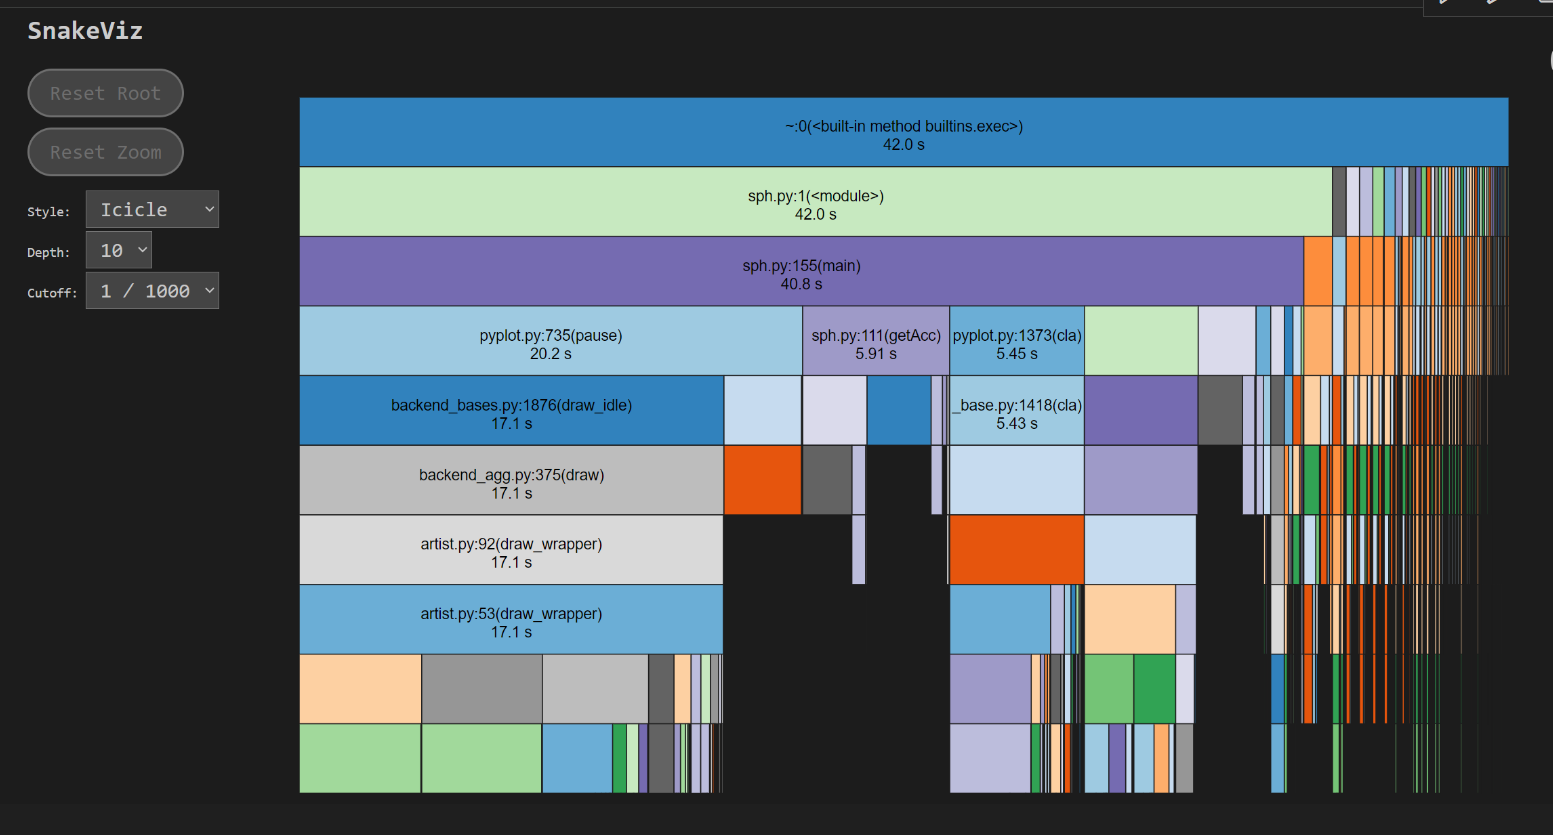

## Profiling with memory_profile

In [7]:
! python -m memory_profiler sph.py

Figure(320x400)


In [8]:
! python -m mprof run sph.py

mprof.py: Sampling memory every 0.1s
running new process
running as a Python program...
Figure(320x400)


In [9]:
! python -m mprof plot mprofile_20250123115442.dat

^C


Figure(1260x540)


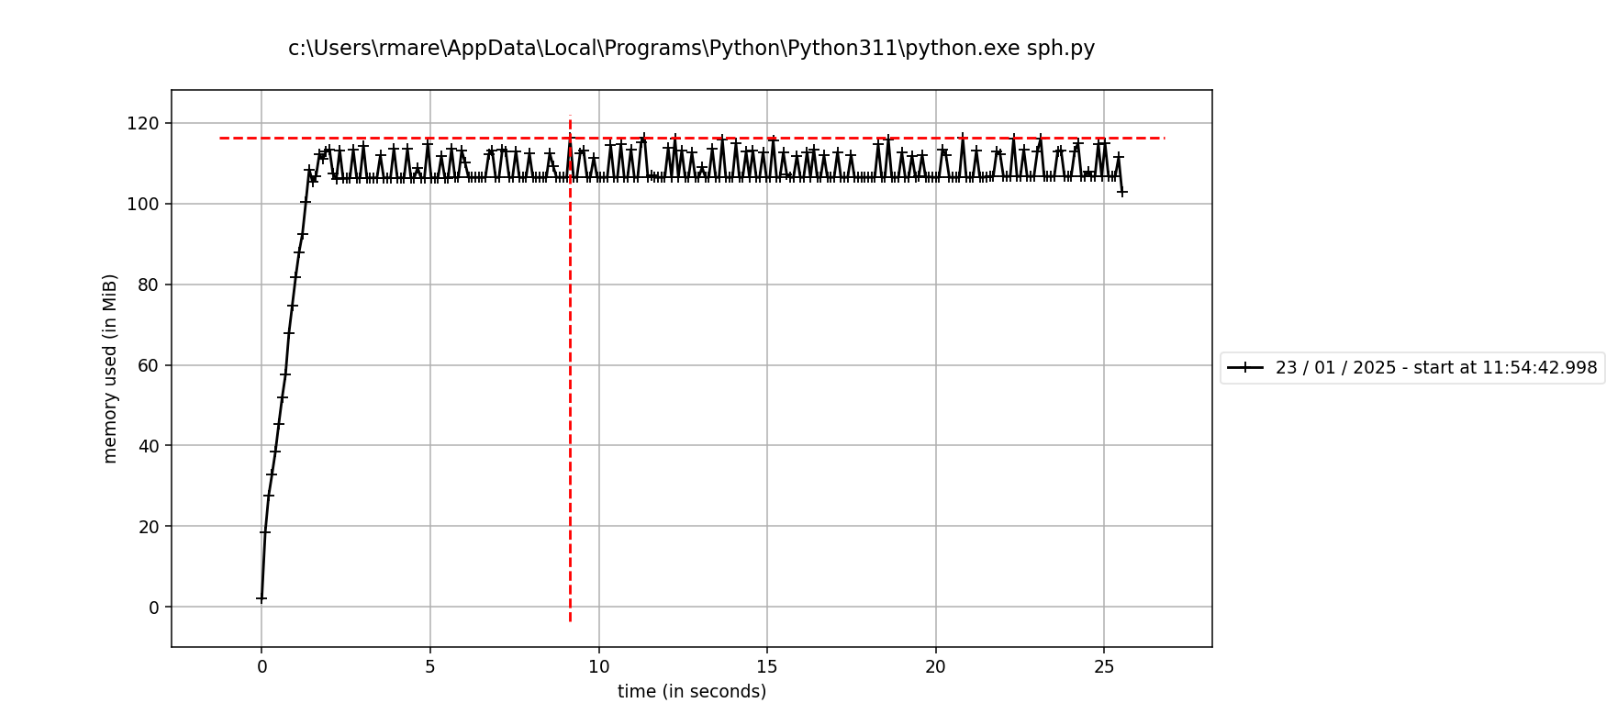

## Profiling with line_profiler

In [15]:
! python -m kernprof -l sph_profile.py

Figure(320x400)
Wrote profile results to sph_profile.py.lprof
Inspect results with:
c:\Users\rmare\AppData\Local\Programs\Python\Python311\python.exe -m line_profiler -rmt "sph_profile.py.lprof"


In [16]:
! python -m line_profiler -rmt "sph_profile.py.lprof"

Timer unit: 1e-06 s

Total time: 0.0054135 s
File: sph_profile.py
Function: getPressure at line 96

Line #      Hits         Time  Per Hit   % Time  Line Contents
    96                                           @profile	
    97                                           def getPressure(rho, k, n):
    98                                           	"""
    99                                           	Equation of State
   100                                           	rho   vector of densities
   101                                           	k     equation of state constant
   102                                           	n     polytropic index
   103                                           	P     pressure
   104                                           	"""
   105                                           	
   106       301       5209.8     17.3     96.2  	P = k * rho**(1+1/n)
   107                                           	
   108       301        203.7      0.7      3.8  	retur